# CSE 6730 Project Checkpoint
# Traffic flow simulation: case study of Atlanta traffic
### Team members: Shu Bin, Qinyu Wang, Zijian Li

### Jupyter notebook environment setup

In [65]:
# Import packages used in this notebook
import math 
import time 
import numpy as np 
import pandas as pd 
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import Image

## 1. Introduction
The project objective is to build a mathematical model to simulate the traffic flow in Atlanta. The ultimate goal is to understand the traffic phenomena in order to optimize traffic networks, alleviate congestion, maximize traffic flow and decrease accident rate. To validify the reliability of our models, we will perform case studies via simulating the real traffic data in Atlanta with our models. The implemented models would be tweaked based on the validation.

## 2. Data collection
The Atlanta traffic data is collected from the website of Georgia Department of Transportation (GDOT):
https://gdottrafficdata.drakewell.com/publicmultinodemap.asp

![The Map showing the location distribution of sites that monitors traffic](GA_gdot_plot.png)

The green triangles symbolize active continuous count station (CCS) which are the sources in this project for collecting the traffic data. For active CCS, the hourly real-time traffic flow (volume) and speed data are monitored. An example site data of weekly (03/14/2021 - 03/20/2021) volume and speed for station 135-6285 - I-85 of Jimmy Carter Blvd @Graves Rd NW, ATL is shown below:

![The weekly volume data for site 135-6285](1356285_weekly_volume_plot.png)

![The weekly speed data for site 135-6285](1356285_weekly_speed_plot.png)

We compile the March 2021 traffic flow and speed data of four sites on the I-85 road into .csv files which are used in the modeling simulation and verification.
* **Station 1**: I-85 at North Druid Hills Road (station ID: 089-3323)
* **Station 2**: I-85/SR403 bn I-285 & Chamblee Tucker Rd, ATL (station ID: 089-3332)
* **Station 3**: I-85 W of Jimmy Carter Blvd @Graves Rd NW, ATL (station ID: 135-6285)
* **Station 4**: I-85 btwn Jimmy Carter & Indian Trail, Norcross (station ID: 135-6287)

<br/><br/>
<div>
<img src="GA_gdot_plot.png" width="500"/>
</div>

## 3. Method and results
We intend to simulate the traffic flow with two models (progressively increasing in complexity). The first model would simulate the traffic flow with linear partial differential equations (PDE). This model simplifies the discrete traffic flow as continuous vehicle density. We would solve the PDEs analitically with and without assuming constant density and compare with the results derived from the iterative approach (Runge-Kutta 4th order). The second model (non-linear) would focus on more realistic conditions via taking into account more complex effects, such as the traffic lights, intersections, entrances and exits, etc.

### 3.1 Linear PDE model
In the linear PDE model, the traffic flow (the number of passing cars per unit time) is formulated as a function of position and time given the initial traffic density (the number of passing cars per unit length). The variables included in this model are
* **traffic flow**: $J$
* **position**: $x$
* **time**: $t$
* **vehicle density**: $\rho$
* **vehicle velocity**: $v$

For the purpose of simulating the traffic flow on a first-order, we make the following assumptions:
1. The vehicle density is continuous. It means that our approach does not use individual car behavior to implement the traffic flow simulation.
2. The vehicle motion is unidirectional from left to right on a one-lane road of infinite length.
3. All vehicles are assumed to have the same length ($L$) and they are evenly spaced at distance $d$, which is simplified as a uniform distribution model (the vehicle density is homogeneous along the infinite lane).
4. All other factors are not considered in the basic implementation of the model, but they might be tested and discussed given the progress and availability of the schedule.

#### 3.1.1 Linear PDE formulation
The vehicle density $\rho$ is formulated as a function of position $x$ and time $t$. The vehicle density at position $x_0$ and time $t_0$ is calculated as follows according to the definition.
\begin{array}{1l}\\
\rho(x_0, t_0) = \frac{1}{L + d} \qquad \text{(Eq. 1)}\\
\end{array}

Given the non-negativity of vehicle spacing $d$, the traffic density is upper bounded by $\frac{1}{L}$.
<br>The traffic flow $J$ can be expressed as a linear combination of vehicle speed and traffic density as follows
\begin{array}{1l}\\
J(x_0, t_0) = \rho(x_0, t_0) * v(x_0, t_0) \qquad \text{(Eq. 2)}\\
\end{array}

<br>Substitute Eq. 1 in Eq. 2, we get
\begin{array}{1l}\\
J(x_0, t_0) = \frac{v(x_0, t_0)}{L + d} \qquad \text{(Eq. 3)}\\
\end{array}

Consider a position interval $\Delta x$ and time interval $\Delta t$ around $x_0$ and $t_0$, according to the \textit{Balance law} for traffic density, the following equation can be derived
\begin{array}{1l}\\
\Delta x * (\rho(x_0, t_0 + \Delta t)- \rho(x_0, t_0)) = \Delta t * (J(x_0 + \Delta x, t_0) - J(x_0, t_0)) \qquad \text{(Eq. 4)}\\
\end{array}

After conducting Taylor expansion on both sides of Eq. 4 and omitting the third-order in terms of $\Delta x$ and $\Delta t$, we get
\begin{array}{1l}\\
\frac{\partial \rho}{\partial t} = - \frac{\partial J}{\partial x} \qquad \text{(Eq. 5)}\\
\end{array}

According to Eq.2, substitute $J$ with $\rho v$, the linear PDE model for traffic flow is
\begin{array}{1l}\\
\frac{\partial \rho}{\partial t} + \frac{\partial \rho v}{\partial x} = 0 \qquad \text{(Eq. 6)}\\
\frac{\partial \rho}{\partial t} + \rho \frac{\partial v}{\partial x} + v \frac{\partial \rho}{\partial x} = 0 \qquad \text{(Eq. 7)}\\
\end{array}

Eq. 6 (or Eq. 7) is the expression of continuous traffic flow equation.
<br>Since there are two scenarios of traffic density (spatially homogeneous and spatially heterogenous) between adjacent stations in real traffic, they are separately simulated and discussed below.

#### 3.1.2 Spatially homogeneous traffic density
If there is no intersections between adjacent stations, the traffic densities of these two stations are normally similar with small discrepancy. An example of this scenario is illustrated below. We extract the daily traffic flow and speed data (**March 15, 2021, Monday**) of two adjacent stations on the I-85 road without intersections in between. The information of these two stations are as follows.
* **Entrance (Station 3)**: I-85 W of Jimmy Carter Blvd @Graves Rd NW, ATL (station ID: 135-6285)
* **Exit (Station 4)**: I-85 btwn Jimmy Carter & Indian Trail, Norcross (station ID: 135-6287)

![The plot showing the location of entrance and exit](entrance_exit_plot.png)

The traffic density at time $t_n$ at location $x_i$ is calculated as the result of traffic flow dividing speed.
\begin{array}{1l}\\
\rho(x_i, t_n) = \frac{J(x_i, t_n)}{v(x_i, t_n)} \qquad \text{(Eq. 8)}\\
\end{array}

The comparision of traffic density on March 15, 2021 of the entrance and the exit is shown below. 

## Validation 1:  ideal constant density
* **Validate equations**: 
\begin{array}{1l}\\
\rho(x, t) = f(x - v * t)\\
x(t) = v * t + x_0\\
\end{array}
* **Data source**: using urban daily **Atlanta** traffic data from https://gdottrafficdata.drakewell.com/publicmultinodemap.asp 
* **Entrance**: I-85 W of Jimmy Carter Blvd @Graves Rd NW, ATL (station ID: 135-6285)
* **Exit**: I-85 btwn Jimmy Carter & Indian Trail, Norcross (station ID: 135-6287)
* **Date**: 03/15/2021 (Monday)

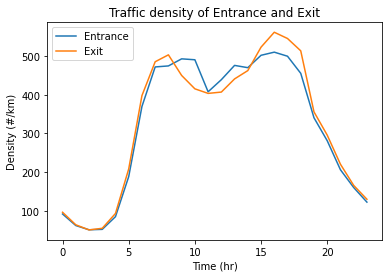

In [137]:
# Read .csv file and extract column data
col_name_val1 = ['entrance_volume', 'entrance_speed', 'exit_volume', 'exit_speed','time'] 
data_val1 = pd.read_csv('gdot_1356285_1356287_031521_firstValidation.csv', names=col_name_val1) 
entrance_volume = data_val1.loc[1:,'entrance_volume'].tolist()
exit_volume = data_val1.loc[1:,'exit_volume'].tolist() 
entrance_speed = data_val1.loc[1:,'entrance_speed'].tolist()
exit_speed = data_val1.loc[1:,'exit_speed'].tolist()
time_val1 = data_val1.loc[1:,'time'].tolist()
flow_data_size_val1 = len(entrance_volume)

# Convert data from format string to float
for i in range(flow_data_size_val1):
    entrance_volume[i] = float(entrance_volume[i])
    exit_volume[i] = float(exit_volume[i])
    entrance_speed[i] = float(entrance_speed[i])
    exit_speed[i] = float(exit_speed[i])
    time_val1[i] = float(time_val1[i])

# Calculate traffic density
entrance_density = np.zeros(flow_data_size_val1)
exit_density = np.zeros(flow_data_size_val1)
for i in range(flow_data_size_val1):
  entrance_density[i] = entrance_volume[i] / entrance_speed[i]
  exit_density[i] = exit_volume[i] / exit_speed[i]

# Plot traffic density of entrance and exit
plt.plot(time_val1, entrance_density*1.60934, label='Entrance')
plt.plot(time_val1, exit_density*1.60934, label='Exit')
plt.title('Traffic density of Entrance and Exit')
plt.xlabel('Time (hr)')
plt.ylabel('Density (#/km)')
plt.legend(loc= 'upper left')
plt.show()

The result shows that the traffic density at the two stations generally approximate each other although some variations exit during the day. It demonstrates that the traffic density is roughly spatially homogeneous if there is no intersections. With this assumption, the traffic flow of a targeted location can be estimated by the traffic density of another location and the speed of the targeted location. For instance, we estimate the traffic flow of the exit by leveraging the traffic density of the entrace as follows.

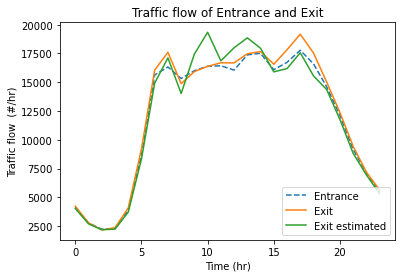

In [138]:
# Estimate exit volume based on entrance density and exit speed
exit_volume_estimated = np.zeros(flow_data_size_val1)
for i in range(flow_data_size_val1):
    exit_volume_estimated[i] = entrance_density[i] * exit_speed[i]
    
# Calculate absolute error between estimated traffic flow and true value for exit 
# entrance_exit_abs_error = np.zeros(flow_data_size_val1)
# for i in range(flow_data_size_val1):
#   entrance_exit_abs_error[i] = 100 * abs((exit_volume_estimated[i]-exit_volume[i])/exit_volume[i])

# Plot comparison of entrance and exit traffic flow (volume) data
plt.plot(time_val1, entrance_volume, '--', label='Entrance') 
plt.plot(time_val1, exit_volume, label='Exit')
plt.plot(time_val1, exit_volume_estimated, label='Exit estimated')
plt.title('Traffic flow of Entrance and Exit') 
plt.xlabel('Time (hr)') 
plt.ylabel('Traffic flow  (#/hr)') 
plt.legend(loc= 'lower right')
plt.show()

# Plot absolute error
# plt.plot(time_val1, entrance_exit_abs_error) 
# plt.title('Relative percentage error between Entrance & Exit') 
# plt.xlabel('Time (hr)') 
# plt.ylabel('Percentage error (%)') 
# plt.show()

The above plot shows that during the time slot that the two stations have similar traffic density, the estimated traffic flow approximates the true traffic flow very well. However, the error of the estimation increases for the time window where relatively large discrepancy of traffic density occurs.

* **Validation 1**: test with Qinyu's data
* **Same** entrance and exit locations
* **Date**: 03/21/2021 (Monday)

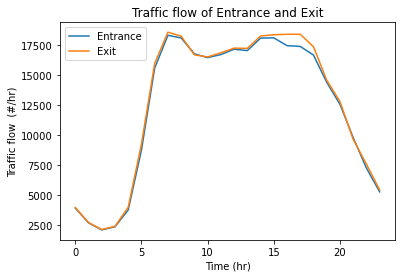

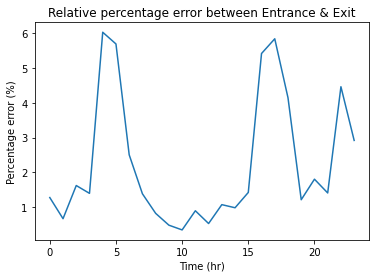

In [22]:
# Read .csv file and extract column data
col_name_val1 = ['entrance_volume', 'entrance_speed', 'exit_volume', 'exit_speed','time'] 
data_val1 = pd.read_csv('gdot_1356285_1356287_032221_firstValidation.csv', names=col_name_val1) 
entrance_volume = data_val1.loc[1:,'entrance_volume'].tolist()
exit_volume = data_val1.loc[1:,'exit_volume'].tolist() 
time_val1 = data_val1.loc[1:,'time'].tolist()
flow_data_size_val1 = len(entrance_volume)

# Convert data from format string to float
for i in range(flow_data_size_val1):
    entrance_volume[i] = float(entrance_volume[i])
    exit_volume[i] = float(exit_volume[i])
    time_val1[i] = float(time_val1[i])

# Calculate absolute error between the entrance and exit
entrance_exit_abs_error = np.zeros(flow_data_size_val1)
for i in range(flow_data_size_val1):
  entrance_exit_abs_error[i] = 100 * abs((entrance_volume[i]-exit_volume[i])/entrance_volume[i])
#print(entrance_exit_abs_error)

# Plot comparison of entrance and exit traffic flow (volume) data
plt.plot(time_val1, entrance_volume, label='Entrance') 
plt.plot(time_val1, exit_volume, label='Exit')
plt.title('Traffic flow of Entrance and Exit') 
plt.xlabel('Time (hr)') 
plt.ylabel('Traffic flow  (#/hr)') 
plt.legend(loc= 'upper left')
plt.show()

# Plot absolute error
plt.plot(time, entrance_exit_abs_error) 
plt.title('Relative percentage error between Entrance & Exit') 
plt.xlabel('Time (hr)') 
plt.ylabel('Percentage error (%)') 
plt.show()

* **Validation 1**: test with the reference report
* **Same** entrance and exit locations
* **Date**: 01/06/2019 (Sunday)

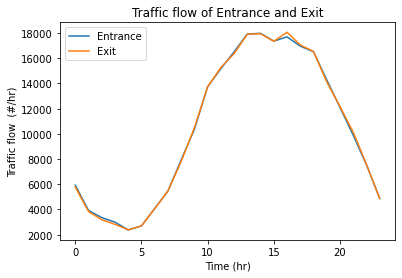

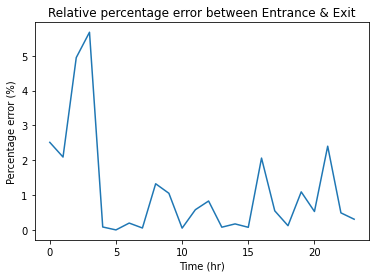

In [23]:
# Read .csv file and extract column data
col_name_val1_ref = ['entrance_volume', 'entrance_speed', 'exit_volume', 'exit_speed','time'] 
data_val1_ref = pd.read_csv('gdot_1356285_1356287_010619_firstValidation.csv', names=col_name_val1_ref) 
entrance_volume_ref = data_val1_ref.loc[1:,'entrance_volume'].tolist()
exit_volume_ref = data_val1_ref.loc[1:,'exit_volume'].tolist() 
time_val1_ref = data_val1_ref.loc[1:,'time'].tolist()
flow_data_size_val1_ref = len(entrance_volume)

# Convert data from format string to float
for i in range(flow_data_size_val1_ref):
    entrance_volume_ref[i] = float(entrance_volume_ref[i])
    exit_volume_ref[i] = float(exit_volume_ref[i])
    time_val1_ref[i] = float(time_val1_ref[i])

# Calculate absolute error between the entrance and exit
entrance_exit_abs_error_ref = np.zeros(flow_data_size_val1_ref)
for i in range(flow_data_size_val1_ref):
  entrance_exit_abs_error_ref[i] = 100 * abs((entrance_volume_ref[i]-exit_volume_ref[i])/entrance_volume_ref[i])
#print(entrance_exit_abs_error)

# Plot comparison of entrance and exit traffic flow (volume) data
plt.plot(time_val1_ref, entrance_volume_ref, label='Entrance') 
plt.plot(time_val1_ref, exit_volume_ref, label='Exit')
plt.title('Traffic flow of Entrance and Exit') 
plt.xlabel('Time (hr)') 
plt.ylabel('Traffic flow  (#/hr)') 
plt.legend(loc= 'upper left')
plt.show()

# Plot absolute error
plt.plot(time_val1_ref, entrance_exit_abs_error_ref) 
plt.title('Relative percentage error between Entrance & Exit') 
plt.xlabel('Time (hr)') 
plt.ylabel('Percentage error (%)') 
plt.show()

#### 3.1.3 Spatially heterogeneous traffic density
Another scenario is that the traffic densities of the adjacent stations are different. This case normally appears when there are intersections between the stations. The potential imbalance between the input and output traffic flux at the intersections may cause the difference in the traffic density. We extract the daily (**March 15, 2021, Monday**) traffic data of a pair of adjacent stations (Station 2 and 3) with an intersection in between to illustrate this case. The geographic locations of Station 2 and 3 together with the two boundaries Station 1 and 4 (used in the simulation) are shown below.

![The plot showing the locations of four stations](station_1to4_plot.png)

The comparison of traffic density between Station 2 and 3 is shown below.

## Validation 2:  density varies
* **Validate equations**: 
\begin{array}{1l}\\
v = v_{max} (1 - \frac{\rho}{\rho_{max}})\\
J = \rho v_{max} (1 - \frac{\rho}{\rho_{max}})\\
\end{array}                 
* **Data source**: using urban daily **Atlanta** traffic data from https://gdottrafficdata.drakewell.com/publicmultinodemap.asp 
* **Station 1**: I-85 at North Druid Hills Road (station ID: 089-3323)
* **Station 2**: I-85/SR403 bn I-285 & Chamblee Tucker Rd, ATL (station ID: 089-3332)
* **Station 3**: I-85 W of Jimmy Carter Blvd @Graves Rd NW, ATL (station ID: 135-6285)
* **Station 4**: I-85 btwn Jimmy Carter & Indian Trail, Norcross (station ID: 135-6287)
* **Date**: 03/15/2021 (Monday)

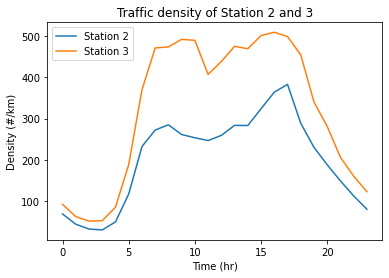

In [139]:
# Read .csv file and extract column data
col_name_val2 = ['volume_S1', 'speed_S1', 'volume_S2', 'speed_S2','volume_S3', 'speed_S3','volume_S4', 'speed_S4','time'] 
data_val2 = pd.read_csv('gdot_0893323_0893332_1356285_1356287_031521_secondValidation.csv', names=col_name_val2) 
volume_S1 = data_val2.loc[1:,'volume_S1'].tolist() 
volume_S2 = data_val2.loc[1:,'volume_S2'].tolist() 
volume_S3 = data_val2.loc[1:,'volume_S3'].tolist() 
volume_S4 = data_val2.loc[1:,'volume_S4'].tolist() 
speed_S1 = data_val2.loc[1:,'speed_S1'].tolist() 
speed_S2 = data_val2.loc[1:,'speed_S2'].tolist() 
speed_S3 = data_val2.loc[1:,'speed_S3'].tolist() 
speed_S4 = data_val2.loc[1:,'speed_S4'].tolist() 
time_val2 = data_val2.loc[1:,'time'].tolist()
flow_data_size_val2 = len(volume_S1)

# Convert data from format string to float
for i in range(flow_data_size_val2):
    volume_S1[i] = float(volume_S1[i])
    volume_S2[i] = float(volume_S2[i])
    volume_S3[i] = float(volume_S3[i])
    volume_S4[i] = float(volume_S4[i])
    speed_S1[i] = float(speed_S1[i])
    speed_S2[i] = float(speed_S2[i])
    speed_S3[i] = float(speed_S3[i])
    speed_S4[i] = float(speed_S4[i])
    time_val2[i] = float(time_val2[i])

# Calculate density for each station & density_max and speed_max from Station 1 and 4
density_S1 = np.zeros(flow_data_size_val2)
density_S2 = np.zeros(flow_data_size_val2)
density_S3 = np.zeros(flow_data_size_val2)
density_S4 = np.zeros(flow_data_size_val2)
density_max = np.zeros(flow_data_size_val2)
speed_max = np.zeros(flow_data_size_val2)

for i in range(flow_data_size_val2):
  density_S1[i] = volume_S1[i] / speed_S1[i]
  density_S2[i] = volume_S2[i] / speed_S2[i]
  density_S3[i] = volume_S3[i] / speed_S3[i]
  density_S4[i] = volume_S4[i] / speed_S4[i]
  density_max[i] = (speed_S1[i]*density_S4[i] - speed_S4[i]*density_S1[i]) / (speed_S1[i] - speed_S4[i])
  speed_max[i] = speed_S1[i] / (1 - density_S1[i]/density_max[i])
  #density_max[i] = (speed_S1[i]*density_S2[i] - speed_S2[i]*density_S1[i]) / (speed_S1[i] - speed_S2[i])
  #speed_max[i] = speed_S1[i] / (1 - density_S1[i]/density_max[i])
  #density_max[i] = (speed_S2[i]*density_S3[i] - speed_S3[i]*density_S2[i]) / (speed_S2[i] - speed_S3[i])
  #speed_max[i] = speed_S2[i] / (1 - density_S2[i]/density_max[i])

# Plot density of Station 2 and 3
#plt.plot(time_val2, density_S1, label='Station 1')
plt.plot(time_val2, density_S2*1.60934, label='Station 2')
plt.plot(time_val2, density_S3*1.60934, label='Station 3')
#plt.plot(time_val2, density_S4, label='Station 4')
plt.title('Traffic density of Station 2 and 3')
plt.xlabel('Time (hr)')
plt.ylabel('Density (#/km)')
plt.legend(loc= 'upper left')
plt.show()

The above plot shows that there are large difference between the Station 2 and 3, especially during the day time. Hence, the assumption of spatially homogeneous traffic density no longer holds, and it is expected that to estimate the traffic flow of Station 3 via the traffic density of Station 2 would induce large errors.

The idea is to explore the correlation between the speed and the traffic density from the traffic data of Station 1 and 4 and then use this derived correlation to fit the traffic flow given the density data for Station 2 and 3.
    
Two approaches have been tested. The first approach is to assume a linear velocity formulated by the **Greenshields** model as follows.
\begin{array}{1l}\\
v = v_{max} (1 - \frac{\rho}{\rho_{max}}) \qquad \text{(Eq. 9)}\\
\end{array}

where $v_{max}$ and $\rho_{max}$ are two unknown parameters (for each hour) that can be calculated by plugging hourly traffic data of Station 1 and 4. Then with derived parameters, the estimated traffic flow for Station 2 and 3 can be calculated as the product of true traffic density and estimated speed
\begin{array}{1l}\\   
J = \rho v_{max} (1 - \frac{\rho}{\rho_{max}}) \qquad \text{(Eq. 10)}\\
\end{array}

The second approach is to use **polynomial regression** to fit the correlation. The true corrlations between the traffic density and speed for all four stations and the fitted correlations derived from Greenshields model and polynomial regression (fitted with the traffic data of Station 3) are shown in the scatter plot below. 

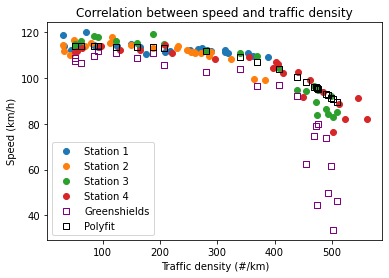

In [174]:
# Concatenate traffic density and speed data of Station 1 and 4
density_S1S4 = np.zeros(2*flow_data_size_val2)
speed_S1S4 = np.zeros(2*flow_data_size_val2)
density_S1S4 = np.concatenate((density_S1, density_S4))
speed_S1S4 = np.concatenate((np.array(speed_S1), np.array(speed_S4)))

# Polynomial fit (3rd order) the correlation between speed and traffic density 
polyfit_coeff = np.polyfit(density_S1S4, speed_S1S4, 3)
rho_v_polyfit = np.poly1d(polyfit_coeff)

# Generate fitted speed for Station 3
speed_S3_fitted = np.zeros(flow_data_size_val2)
speed_S3_fitted = rho_v_polyfit(density_S3)

# Plot the correlation between speed and traffic density for four stations
plt.scatter(density_S1*1.60934, np.array(speed_S1)*1.60934, label='Station 1')
plt.scatter(density_S2*1.60934, np.array(speed_S2)*1.60934, label='Station 2')
plt.scatter(density_S3*1.60934, np.array(speed_S3)*1.60934, label='Station 3')
plt.scatter(density_S4*1.60934, np.array(speed_S4)*1.60934, label='Station 4')
plt.scatter(density_S3*1.60934, speed_max*1.60934*(1 - np.array(density_S3)*1.60934/density_max), facecolors='none', edgecolors='purple', marker='s', label='Greenshields')
plt.scatter(density_S3*1.60934, speed_S3_fitted*1.60934, facecolors='none', edgecolors='k', marker='s', label='Polyfit')
plt.title('Correlation between speed and traffic density')
plt.xlabel('Traffic density (#/km)')
plt.ylabel('Speed (km/h)')
plt.legend(loc= 'lower left')
plt.show()

The results show that the speed derived from the Greenshields model (purple square) is generally lower than the actual value (green dot), while the speed fitted from the polynomial regression (black square) approximates the true value well and generally fall within the main sequence formed by the traffic data of four models. The two fitting approaches are utilized to generate the estimated traffic flow for Station 2 and 3 and are plotted in comparison with the true values as shown below.

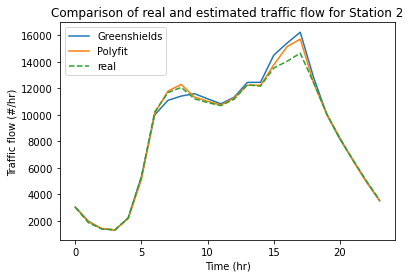

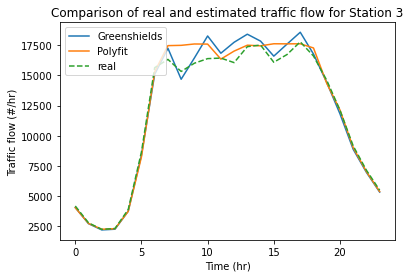

In [177]:
# Calculate estimated traffic flow for Station 2 and 3
#volume_S1_estimated = np.zeros(flow_data_size_val2)
volume_S2_estimated_g = np.zeros(flow_data_size_val2)
volume_S3_estimated_g = np.zeros(flow_data_size_val2)
volume_S2_estimated_p = np.zeros(flow_data_size_val2)
volume_S3_estimated_p = np.zeros(flow_data_size_val2)
#volume_S2_estimated_rho = np.zeros(flow_data_size_val2)
#volume_S3_estimated_rho = np.zeros(flow_data_size_val2)
#volume_S4_estimated = np.zeros(flow_data_size_val2)

for i in range(flow_data_size_val2):
    #volume_S1_estimated[i] = density_S1[i] * speed_max[i] * (1 - density_S1[i]/density_max[i])
    volume_S2_estimated_g[i] = density_S2[i] * speed_max[i] * (1 - density_S2[i]/density_max[i])
    volume_S3_estimated_g[i] = density_S3[i] * speed_max[i] * (1 - density_S3[i]/density_max[i])
    volume_S2_estimated_p[i] = density_S2[i] * rho_v_polyfit(density_S2[i])
    volume_S3_estimated_p[i] = density_S3[i] * rho_v_polyfit(density_S3[i])
    #volume_S4_estimated[i] = density_S4[i] * speed_max[i] * (1 - density_S4[i]/density_max[i])
    #volume_S2_estimated_rho[i] = speed_S2[i] * density_max[i] * (1 - speed_S2[i]/speed_max[i])
    #volume_S3_estimated_rho[i] = speed_S3[i] * density_max[i] * (1 - speed_S3[i]/speed_max[i])

# Plot the real and estimated traffic flow for Station 1
# plt.plot(time_val2, volume_S1_estimated, label='estimated')
# plt.plot(time_val2, volume_S1, label='real')
# plt.title('Comparison of real and estimated traffic flow for Station 1')
# plt.xlabel('Time (hr)')
# plt.ylabel('Traffic flow (#/hr)')
# plt.legend(loc= 'upper left')
# plt.show()

# Plot the real and estimated traffic flow for Station 2
plt.plot(time_val2, volume_S2_estimated_g, label='Greenshields')
#plt.plot(time_val2, volume_S2_estimated_rho, label='rho estimated')
plt.plot(time_val2, volume_S2_estimated_p, label='Polyfit')
plt.plot(time_val2, volume_S2, '--', label='real')
plt.title('Comparison of real and estimated traffic flow for Station 2')
plt.xlabel('Time (hr)')
plt.ylabel('Traffic flow (#/hr)')
plt.legend(loc= 'upper left')
plt.show()

# Plot the real and estimated traffic flow for Station 3
plt.plot(time_val2, volume_S3_estimated_g, label='Greenshields')
#plt.plot(time_val2, volume_S3_estimated_rho, label='rho estimated')
plt.plot(time_val2, volume_S3_estimated_p, label='Polyfit')
plt.plot(time_val2, volume_S3, '--', label='real')
plt.title('Comparison of real and estimated traffic flow for Station 3')
plt.xlabel('Time (hr)')
plt.ylabel('Traffic flow (#/hr)')
plt.legend(loc= 'upper left')
plt.show()

# Plot the real and estimated traffic flow for Station 4
# plt.plot(time_val2, volume_S4_estimated, label='estimated')
# plt.plot(time_val2, volume_S4, label='real')
# plt.title('Comparison of real and estimated traffic flow for Station 4')
# plt.xlabel('Time (hr)')
# plt.ylabel('Traffic flow (#/hr)')
# plt.legend(loc= 'upper left')
# plt.show()

The figures show that for both Station 2 and 3 the traffic flow fitted with polynomial regression (orange curve) approximates the true values (green dashed line) better compared with the fitting from the Greenshields model (blue curve).

* **Validation 2**: test with Qinyu's data
* **Station 1**: I-85 SB to I-285 WB - Ramp (station ID: 089-9611)
* **Station 2**: I-85 W of Jimmy Carter Blvd @Graves Rd NW, ATL (station ID: 135-6285)
* **Station 3**: I-85 btwn Jimmy Carter & Indian Trail, Norcross (station ID: 135-6287)
* **Station 4**: SR 316 WB TO I-85 SB - Ramp (station ID: 135-9528)
* **Date**: 03/22/2021 (Monday)

[  -7.03721678   -6.26900499   -4.95070429   -0.5347879    -0.25118593
   -0.23067865   -1.72236568    9.46452244    3.75960609  -14.01623422
   -8.14144845  -11.6560282    -5.35334295   66.33341346   -1.89637766
   -2.19629661   -4.82639079   -7.48350978  -13.69000511   -4.07972626
   -6.17455085 -137.43750542  -16.48528593   -8.84254019]


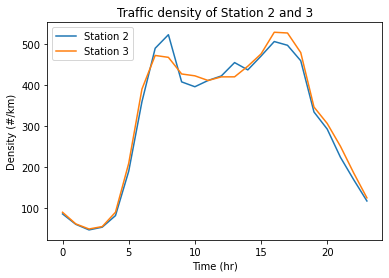

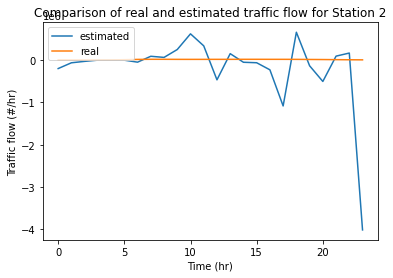

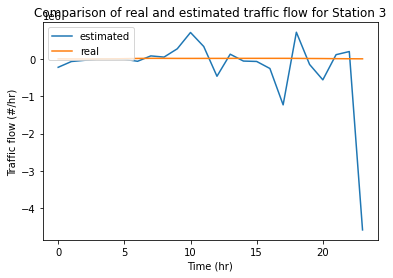

In [74]:
# Read .csv file and extract column data
col_name_val2 = ['volume_S1', 'speed_S1', 'volume_S2', 'speed_S2','volume_S3', 'speed_S3','volume_S4', 'speed_S4','time'] 
data_val2 = pd.read_csv('gdot_0899611_1356285_1356287_1359528_032221_secondValidation.csv', names=col_name_val2) 
volume_S1 = data_val2.loc[1:,'volume_S1'].tolist() 
volume_S2 = data_val2.loc[1:,'volume_S2'].tolist() 
volume_S3 = data_val2.loc[1:,'volume_S3'].tolist() 
volume_S4 = data_val2.loc[1:,'volume_S4'].tolist() 
speed_S1 = data_val2.loc[1:,'speed_S1'].tolist() 
speed_S2 = data_val2.loc[1:,'speed_S2'].tolist() 
speed_S3 = data_val2.loc[1:,'speed_S3'].tolist() 
speed_S4 = data_val2.loc[1:,'speed_S4'].tolist() 
time_val2 = data_val2.loc[1:,'time'].tolist()
flow_data_size_val2 = len(volume_S1)

# Convert data from format string to float
for i in range(flow_data_size_val2):
    volume_S1[i] = float(volume_S1[i])
    volume_S2[i] = float(volume_S2[i])
    volume_S3[i] = float(volume_S3[i])
    volume_S4[i] = float(volume_S4[i])
    speed_S1[i] = float(speed_S1[i])
    speed_S2[i] = float(speed_S2[i])
    speed_S3[i] = float(speed_S3[i])
    speed_S4[i] = float(speed_S4[i])
    time_val2[i] = float(time_val2[i])

# Calculate density for each station & density_max and speed_max from Station 1 and 4
density_S1 = np.zeros(flow_data_size_val2)
density_S2 = np.zeros(flow_data_size_val2)
density_S3 = np.zeros(flow_data_size_val2)
density_S4 = np.zeros(flow_data_size_val2)
density_max = np.zeros(flow_data_size_val2)
speed_max = np.zeros(flow_data_size_val2)

for i in range(flow_data_size_val2):
  density_S1[i] = volume_S1[i] / speed_S1[i]
  density_S2[i] = volume_S2[i] / speed_S2[i]
  density_S3[i] = volume_S3[i] / speed_S3[i]
  density_S4[i] = volume_S4[i] / speed_S4[i]
  density_max[i] = (speed_S1[i]*density_S4[i] - speed_S4[i]*density_S1[i]) / (speed_S1[i] - speed_S4[i])
  speed_max[i] = speed_S1[i] / (1 - density_S1[i]/density_max[i])
  #density_max[i] = (speed_S1[i]*density_S2[i] - speed_S2[i]*density_S1[i]) / (speed_S1[i] - speed_S2[i])
  #speed_max[i] = speed_S1[i] / (1 - density_S1[i]/density_max[i])
  #density_max[i] = (speed_S2[i]*density_S3[i] - speed_S3[i]*density_S2[i]) / (speed_S2[i] - speed_S3[i])
  #speed_max[i] = speed_S2[i] / (1 - density_S2[i]/density_max[i])
    
# Calculate estimated traffic flow for Station 2 and 3
#volume_S1_estimated = np.zeros(flow_data_size_val2)
volume_S2_estimated = np.zeros(flow_data_size_val2)
volume_S3_estimated = np.zeros(flow_data_size_val2)
#volume_S4_estimated = np.zeros(flow_data_size_val2)

for i in range(flow_data_size_val2):
    #volume_S1_estimated[i] = density_S1[i] * speed_max[i] * (1 - density_S1[i]/density_max[i])
    volume_S2_estimated[i] = density_S2[i] * speed_max[i] * (1 - density_S2[i]/density_max[i])
    volume_S3_estimated[i] = density_S3[i] * speed_max[i] * (1 - density_S3[i]/density_max[i])
    #volume_S4_estimated[i] = density_S4[i] * speed_max[i] * (1 - density_S4[i]/density_max[i])
print(1 - density_S2/density_max)

# Plot density of Station 2 and 3
#plt.plot(time_val2, density_S1, label='Station 1')
plt.plot(time_val2, density_S2*1.60934, label='Station 2')
plt.plot(time_val2, density_S3*1.60934, label='Station 3')
#plt.plot(time_val2, density_S4, label='Station 4')
plt.title('Traffic density of Station 2 and 3')
plt.xlabel('Time (hr)')
plt.ylabel('Density (#/km)')
plt.legend(loc= 'upper left')
plt.show()

# Plot the real and estimated traffic flow for Station 1
# plt.plot(time_val2, volume_S1_estimated, label='estimated')
# plt.plot(time_val2, volume_S1, label='real')
# plt.title('Comparison of real and estimated traffic flow for Station 1')
# plt.xlabel('Time (hr)')
# plt.ylabel('Traffic flow (#/hr)')
# plt.legend(loc= 'upper left')
# plt.show()

# Plot the real and estimated traffic flow for Station 2
plt.plot(time_val2, volume_S2_estimated, label='estimated')
plt.plot(time_val2, volume_S2, label='real')
plt.title('Comparison of real and estimated traffic flow for Station 2')
plt.xlabel('Time (hr)')
plt.ylabel('Traffic flow (#/hr)')
plt.legend(loc= 'upper left')
plt.show()

# Plot the real and estimated traffic flow for Station 3
plt.plot(time_val2, volume_S3_estimated, label='estimated')
plt.plot(time_val2, volume_S3, label='real')
plt.title('Comparison of real and estimated traffic flow for Station 3')
plt.xlabel('Time (hr)')
plt.ylabel('Traffic flow (#/hr)')
plt.legend(loc= 'upper left')
plt.show()

# Plot the real and estimated traffic flow for Station 4
# plt.plot(time_val2, volume_S4_estimated, label='estimated')
# plt.plot(time_val2, volume_S4, label='real')
# plt.title('Comparison of real and estimated traffic flow for Station 4')
# plt.xlabel('Time (hr)')
# plt.ylabel('Traffic flow (#/hr)')
# plt.legend(loc= 'upper left')
# plt.show()

* **Validation 2**: test with the reference report
* **Station 1-4**: same
* **Date**: 02/14/2019 (Thursday)

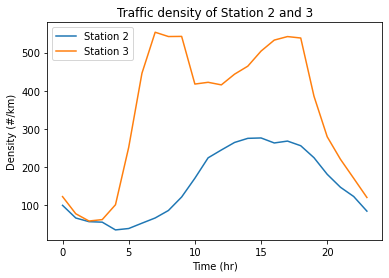

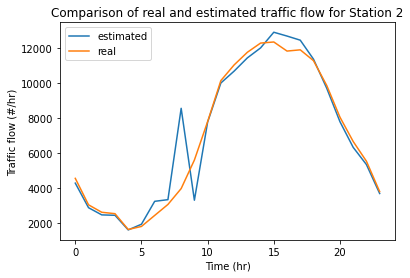

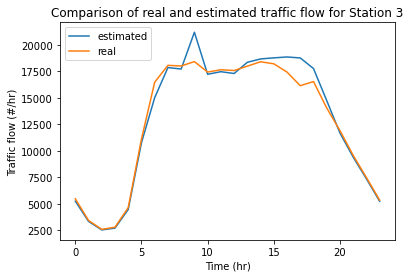

In [75]:
# Read .csv file and extract column data
col_name_val2_ref = ['volume_S1', 'speed_S1', 'volume_S2', 'speed_S2','volume_S3', 'speed_S3','volume_S4', 'speed_S4','time'] 
data_val2_ref = pd.read_csv('gdot_0893323_0893332_1356285_1356287_021419_secondValidation.csv', names=col_name_val2_ref) 
volume_S1_ref = data_val2_ref.loc[1:,'volume_S1'].tolist() 
volume_S2_ref = data_val2_ref.loc[1:,'volume_S2'].tolist() 
volume_S3_ref = data_val2_ref.loc[1:,'volume_S3'].tolist() 
volume_S4_ref = data_val2_ref.loc[1:,'volume_S4'].tolist() 
speed_S1_ref = data_val2_ref.loc[1:,'speed_S1'].tolist() 
speed_S2_ref = data_val2_ref.loc[1:,'speed_S2'].tolist() 
speed_S3_ref = data_val2_ref.loc[1:,'speed_S3'].tolist() 
speed_S4_ref = data_val2_ref.loc[1:,'speed_S4'].tolist() 
time_val2_ref = data_val2_ref.loc[1:,'time'].tolist()
flow_data_size_val2_ref = len(volume_S1_ref)

# Convert data from format string to float
for i in range(flow_data_size_val2_ref):
    volume_S1_ref[i] = float(volume_S1_ref[i])
    volume_S2_ref[i] = float(volume_S2_ref[i])
    volume_S3_ref[i] = float(volume_S3_ref[i])
    volume_S4_ref[i] = float(volume_S4_ref[i])
    speed_S1_ref[i] = float(speed_S1_ref[i])
    speed_S2_ref[i] = float(speed_S2_ref[i])
    speed_S3_ref[i] = float(speed_S3_ref[i])
    speed_S4_ref[i] = float(speed_S4_ref[i])
    time_val2_ref[i] = float(time_val2_ref[i])

# Calculate density for each station & density_max and speed_max from Station 1 and 4
density_S1_ref = np.zeros(flow_data_size_val2_ref)
density_S2_ref = np.zeros(flow_data_size_val2_ref)
density_S3_ref = np.zeros(flow_data_size_val2_ref)
density_S4_ref = np.zeros(flow_data_size_val2_ref)
density_max_ref = np.zeros(flow_data_size_val2_ref)
speed_max_ref = np.zeros(flow_data_size_val2_ref)

for i in range(flow_data_size_val2_ref):
  density_S1_ref[i] = volume_S1_ref[i] / speed_S1_ref[i]
  density_S2_ref[i] = volume_S2_ref[i] / speed_S2_ref[i]
  density_S3_ref[i] = volume_S3_ref[i] / speed_S3_ref[i]
  density_S4_ref[i] = volume_S4_ref[i] / speed_S4_ref[i]
  density_max_ref[i] = (speed_S1_ref[i]*density_S4_ref[i] - speed_S4_ref[i]*density_S1_ref[i]) / (speed_S1_ref[i] - speed_S4_ref[i])
  speed_max_ref[i] = speed_S1_ref[i] / (1 - density_S1_ref[i]/density_max_ref[i])
  #density_max_ref[i] = (speed_S1_ref[i]*density_S2_ref[i] - speed_S2_ref[i]*density_S1_ref[i]) / (speed_S1_ref[i] - speed_S2_ref[i])
  #speed_max_ref[i] = speed_S1_ref[i] / (1 - density_S1_ref[i]/density_max_ref[i])
  #density_max_ref[i] = (speed_S2_ref[i]*density_S3_ref[i] - speed_S3_ref[i]*density_S2_ref[i]) / (speed_S2_ref[i] - speed_S3_ref[i])
  #speed_max_ref[i] = speed_S2_ref[i] / (1 - density_S2_ref[i]/density_max_ref[i])
    
# Calculate estimated traffic flow for Station 2 and 3
#volume_S1_ref_estimated = np.zeros(flow_data_size_val2_ref)
volume_S2_ref_estimated = np.zeros(flow_data_size_val2_ref)
volume_S3_ref_estimated = np.zeros(flow_data_size_val2_ref)
#volume_S4_ref_estimated = np.zeros(flow_data_size_val2_ref)

for i in range(flow_data_size_val2_ref):
    #volume_S1_ref_estimated[i] = density_S1_ref[i] * speed_max_ref[i] * (1 - density_S1_ref[i]/density_max_ref[i])
    volume_S2_ref_estimated[i] = density_S2_ref[i] * speed_max_ref[i] * (1 - density_S2_ref[i]/density_max_ref[i])
    volume_S3_ref_estimated[i] = density_S3_ref[i] * speed_max_ref[i] * (1 - density_S3_ref[i]/density_max_ref[i])
    #volume_S4_ref_estimated[i] = density_S4_ref[i] * speed_max_ref[i] * (1 - density_S4_ref[i]/density_max_ref[i])
    
# Plot density of Station 2 and 3
#plt.plot(time_val2_ref, density_S1_ref*1.60934, label='Station 1')
plt.plot(time_val2_ref, density_S2_ref*1.60934, label='Station 2')
plt.plot(time_val2_ref, density_S3_ref*1.60934, label='Station 3')
#plt.plot(time_val2_ref, density_S4_ref*1.60934, label='Station 4')
plt.title('Traffic density of Station 2 and 3')
plt.xlabel('Time (hr)')
plt.ylabel('Density (#/km)')
plt.legend(loc= 'upper left')
plt.show()

# Plot the real and estimated traffic flow for Station 1
# plt.plot(time_val2_ref, volume_S1_ref_estimated, label='estimated')
# plt.plot(time_val2_ref, volume_S1_ref, label='real')
# plt.title('Comparison of real and estimated traffic flow for Station 1')
# plt.xlabel('Time (hr)')
# plt.ylabel('Traffic flow (#/hr)')
# plt.legend(loc= 'upper left')
# plt.show()

# Plot the real and estimated traffic flow for Station 2
plt.plot(time_val2_ref, volume_S2_ref_estimated, label='estimated')
plt.plot(time_val2_ref, volume_S2_ref, label='real')
plt.title('Comparison of real and estimated traffic flow for Station 2')
plt.xlabel('Time (hr)')
plt.ylabel('Traffic flow (#/hr)')
plt.legend(loc= 'upper left')
plt.show()

# Plot the real and estimated traffic flow for Station 3
plt.plot(time_val2_ref, volume_S3_ref_estimated, label='estimated')
plt.plot(time_val2_ref, volume_S3_ref, label='real')
plt.title('Comparison of real and estimated traffic flow for Station 3')
plt.xlabel('Time (hr)')
plt.ylabel('Traffic flow (#/hr)')
plt.legend(loc= 'upper left')
plt.show()

# Plot the real and estimated traffic flow for Station 4
# plt.plot(time_val2_ref, volume_S4_ref_estimated, label='estimated')
# plt.plot(time_val2_ref, volume_S4_ref, label='real')
# plt.title('Comparison of real and estimated traffic flow for Station 4')
# plt.xlabel('Time (hr)')
# plt.ylabel('Traffic flow (#/hr)')
# plt.legend(loc= 'upper left')
# plt.show()

#### 3.1.4 Iterative approach:  Runge-Kutta 4th order (RK4)
In this section, we explore the iterative method to generate the numerical solution for the continuous traffic flow PDE. Since the discretization of PDE equation requires the parametric formulation of variables, we utilize Greenshields model to represent the correlation between speed and traffic density (Eq. 9) although it performs not as good as the polynomial regression in fitting the traffic flow. With this assumption, the Eq. 7 can be further discretized as
\begin{array}{1l}\\
\frac{\partial \rho}{\partial t} + v_{max} (1 - \frac{2\rho}{\rho_{max}}) \frac{\partial \rho}{\partial x} = 0 \qquad \text{(Eq. 11)}\\
\end{array}

Denote $C(\rho) = v_{max} (1 - \frac{2\rho}{\rho_{max}})$ and apply the *finite difference method*, Eq. 11 can be written as
\begin{array}{1l}\\
\frac{\rho^{n+1}_{j} - \rho^{n}_{j}}{\Delta t} + C(\rho^{n}_{j}) \frac{\rho^{n}_{j} - \rho^{n}_{j-1}}{\Delta x} = 0 \qquad \text{(Eq. 12)}\\
\end{array}

Rearrange the time step $n+1$ term to the left hand side and time step $n$ terms to the right hand side. The final numerical scheme is
\begin{array}{1l}\\
\rho^{n+1}_{j} = \rho^{n}_{j} + C(\rho^{n}_{j}) \frac{\Delta t}{\Delta x} (\rho^{n}_{j} - \rho^{n}_{j-1}) \qquad \text{(Eq. 13)}\\
\end{array}

**Haversine formula**

<br>In Eq. 13, $\Delta x$ denotes the distance between two adjacent stations. Given this distance is the distance between two points on Earth (a sphere), the great-circle distance can be calculated via the haversine formula with the latitudes and longitudes of the two points.

\begin{array}{1l}\\
hav(\Theta) = sin^2(\frac{\phi_2 - \phi_1}{2}) + cos(\phi_1) cos(\phi_2) sin^2(\frac{\lambda_2 - \lambda_1}{2}) \qquad \text{(Eq. 14)}\\
d = r * \Theta = 2r * arcsin(\sqrt{hav(\Theta)}) \qquad \text{(Eq. 15)}\\
\end{array}

where $hav()$ is the haversine funciton, $\Theta$ is the central angle, $\phi$ and $\lambda$ are latitude and longitude of points, respectively, and $r$ is the Earth radius.

<dr>The haversine function is implemented as follows.

## Iterative approach:  Runge-Kutta 4th order (RK4) method
* **Data source**: using urban daily **Atlanta** traffic data from https://gdottrafficdata.drakewell.com/publicmultinodemap.asp 
* **Station 1**: I-85 at North Druid Hills Road (station ID: 089-3323)
* **Station 2**: I-85/SR403 bn I-285 & Chamblee Tucker Rd, ATL (station ID: 089-3332)
* **Date**: 03/15/2021 (Monday)

In [178]:
# Define haversine formula function to calculate the distance on a sphere
def haversine_distance(point_one, point_two):
    lat_1, long_1 = point_one
    lat_2, long_2 = point_two
    earth_radius = 6371  # unit of km
    lat_1_rad = math.radians(lat_1)
    lat_2_rad = math.radians(lat_2)
    delta_lat = math.radians(lat_2 - lat_1)
    delta_long = math.radians(long_2 - long_1)
    hav_theta = math.sin(delta_lat/2)**2 + math.cos(lat_1_rad)*math.cos(lat_2_rad)*(math.sin(delta_long)**2)
    #theta = 2 * math.atan2(math.sqrt(hav_theta), math.sqrt(1-hav_theta))
    theta = 2 * math.asin(math.sqrt(hav_theta))
    distance = earth_radius * theta * 0.539957  # 0.539957 is conversion coefficient
    return distance

**Runge-Kutta 4th order**

<br>Runge-Kutta 4th order is a commonly used iterative method (normally referred as "RK4") to discretize the ordinary differential equation for generating approximate solutions. This method is internally composed of the Euler method. Given an initial value problem of
\begin{array}{1l}\\
\frac{dy}{dt} = f(t, y), \qquad y(t_0) = y_0 \qquad \text{(Eq. 16)}\\
\end{array}

The RK4 method can be expressed as
\begin{array}{1l}\\
y_{n+1} = y_n + \frac{1}{6} h (k_1 + 2k_2 + 2k_3 + k_4) \qquad \text{(Eq. 17)}\\
t_{n+1} = t_n + h \qquad \text{(Eq. 18)}\\
\end{array}

where $h$ is the time step size, and $k_1$, $k_2$, $k_3$, $k_4$ are defined as
\begin{array}{1l}\\
k_1 = f(t_n, y_n) \qquad \text{(Eq. 19)}\\
k_2 = f(t_n + \frac{h}{2}, y_n + h\frac{k_1}{2}) \qquad \text{(Eq. 20)}\\
k_3 = f(t_n + \frac{h}{2}, y_n + h\frac{k_2}{2}) \qquad \text{(Eq. 21)}\\
k_4 = f(t_n + h, y_n + hk_3) \qquad \text{(Eq. 22)}\\
\end{array}

To apply RK4 in Eq. 13, the $f()$ in RK4 method formulates the differential equation of continous traffic flow, specifically $f()$ represents the derivative of traffic density with respect to time ($\frac{\partial \rho}{\partial t}$). The implementation of RK4 in simulating the traffic flow is shown below with the estimated results for Station 2 and 3 compared with the true values and the fitted values from the analytical derivation.

In [179]:
# Define input parameters for RK4
t_initial = 0
num_iteration = 1
sub_step_size = 0.01

# Define station coordinates
coord_S1 = [33.82764, -84.34427]
coord_S2 = [33.88379, -84.26857]

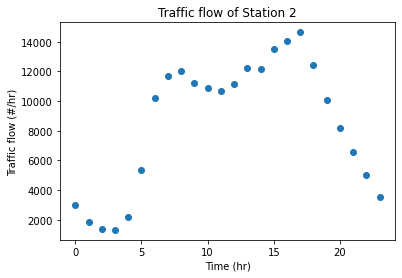

In [180]:
# Assign time variable for Station 1 and 2
time_S1 = time_val2
time_S2 = time_val2

# Plot traffic flow of station 2
plt.scatter(time_S2, volume_S2)
plt.title('Traffic flow of Station 2')
plt.xlabel('Time (hr)')
plt.ylabel('Traffic flow (#/hr)')
plt.show()

In [183]:
# Define traffic flow model ODE (time derivative of traffic density)
def drho_dt(rho, v_cur, v_next, distance):
    return -rho * ((v_next-v_cur)/distance)  # Note this ODE does not involve t

# Define RK4 function
def rungeKutta4th(drho_dt, v_cur, v_next, distance, t0, rho0, h, n):
    
    # Initialize time and traffic density array
    t_array = np.zeros(n+1)
    rho_array = np.zeros(n+1)
    
    # Assign initial conditions
    t_array[0] = t0
    rho_array[0] = rho0
    
    # Interatively calculate traffic density of each time step
    for i in range(1,n+1):
        
        # Calculate k1 to k4 values in RK4 formula
        k1 = drho_dt(rho_array[i-1], v_cur, v_next, distance)
        k2 = drho_dt(rho_array[i-1] + 0.5*k1, v_cur, v_next, distance)
        k3 = drho_dt(rho_array[i-1] + 0.5*k2, v_cur, v_next, distance)
        k4 = drho_dt(rho_array[i-1] + k3, v_cur, v_next, distance)
        
        # Assign updated t and calculated rho to the corresponding time step
        t_array[i] = t_array[i-1] + h
        rho_array[i] = rho_array[i-1] + (1.0/6.0)*h*(k1 + 2*k2 + 2*k3 + k4)
    
    # Return iteratively derived traffic density at time step n
    return rho_array[n]

In [184]:
# Convert speed array to Numpy array
speed_S1_array = np.array(speed_S1)
speed_S2_array = np.array(speed_S2)

# Initialize empty array to store results
rho_S1_initial = np.zeros(len(time_S1))
rho_S2 = np.zeros(len(time_S1))
rho_S2_approx = np.zeros(len(time_S1))
best_step_size = np.zeros(len(time_S1))
volume_S2_approx = np.zeros(len(time_S1))

# Assign values for the first row of density arrays for Station 2
rho_S2[0] = density_S2[0]
rho_S2_approx[0] = rho_S2[0]  # the initial traffic density is assigned with the true value
volume_S2_approx[0] = rho_S2[0] * speed_S2[0]

# Iteratively calculate the estimated traffic density of all time steps (1-23 hours) for Station 1
for i in range(0, len(time_S1)-1):
    
    # Assign speed values of current time step and next time step for Station 1
    v_cur = speed_S1[i]
    v_next = speed_S1[i+1]
    
    # Calculate distance between Station 1 and 2
    dist = haversine_distance(coord_S1, coord_S2)
    
    # Assign initial traffic density value of all time steps for Station 1
    rho_S1_initial[i] = volume_S1[i] / speed_S1[i]
    
    # Create an array with various time step size
    step_size = np.arange(sub_step_size, 1, sub_step_size)
    
    # Collect all results of traffic density of Station 2 of next time step with different time step size
    rho_S2_step_size_res = np.zeros(len(step_size))
    for j in range(0, len(step_size)):
        rho_S2_step_size_res[j] = rungeKutta4th(drho_dt, v_cur, v_next, dist, t_initial, rho_S1_initial[i], step_size[j], int(num_iteration/step_size[j]))
    
    # Select the simulated traffic density value of Station 2 that approximates the true value most
    rho_S2[i+1] = density_S2[i+1]
    rho_S2_approx[i+1] = min(rho_S2_step_size_res, key=lambda x: abs(x-rho_S2[i+1]))
    
    # Estimate the traffic flow value of Station 2 for the next time step
    volume_S2_approx[i+1] = rho_S2_approx[i+1] * speed_S2[i+1]

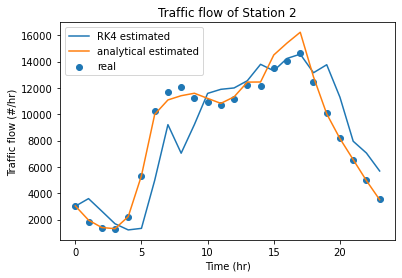

In [185]:
plt.scatter(time_S2, volume_S2, label='real')
plt.plot(time_S2, volume_S2_approx, label='RK4 estimated')
plt.plot(time_S2, volume_S2_estimated, label='analytical estimated')
plt.title('Traffic flow of Station 2')
plt.xlabel('Time (hr)')
plt.ylabel('Traffic flow (#/hr)')
plt.legend(loc= 'upper left')
plt.show()

The above figure shows that RK4 estimated results have relatively large discrepancy from the ground true values compared with the analytical derivation. To be noted, this RK4 implementation simplifies the PDE as the spatially homogeneous traffic density. The consideration of spatially heterogeneous traffic density scenario is still in progress.

### 3.2 Complex model [in progress]
Given many real-world factors in traffic are not considered in the basic model, we expect the performance of the simple model to simulate the traffic data is poor. As a result, our second model would be a non-linear model that incorporates several effects, such as traffic light, intersection, etc. We haven’t figured out what type of non-linear model would be best to fit in this section. We will work on the development of the complex model after literature review and further group discussions. Same as the first model, after the implementation, the validity of the model would be tested on the real traffic data to see if the fitting performance is improved. It is expected that parameter tuning would be involved.

## Reference
[1] Haberman, Richard. Mathematical models: mechanical vibrations, population dynamics, and traffic flow. Vol. 21. Siam, 1998.
<br>[2] http://www.norbertwiener.umd.edu/Education/m3cdocs/Presentation2.pdf
<br>[3] H. Holmes. Introduction to the Foundations of Applied Mathematics. Springer (2009)
<br>[4] https://www.math.nyu.edu/faculty/childres/traffic2.pdf
<br>[5] https://www.sciencedirect.com/science/article/pii/S0377042706002159#bib8